In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

In [2]:
df = pd.read_csv('dataset/Social_Network_Ads.csv')
df.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              400 non-null    int64
 1   EstimatedSalary  400 non-null    int64
 2   Purchased        400 non-null    int64
dtypes: int64(3)
memory usage: 9.5 KB


In [4]:
df.isnull().sum()

Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [5]:
df.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


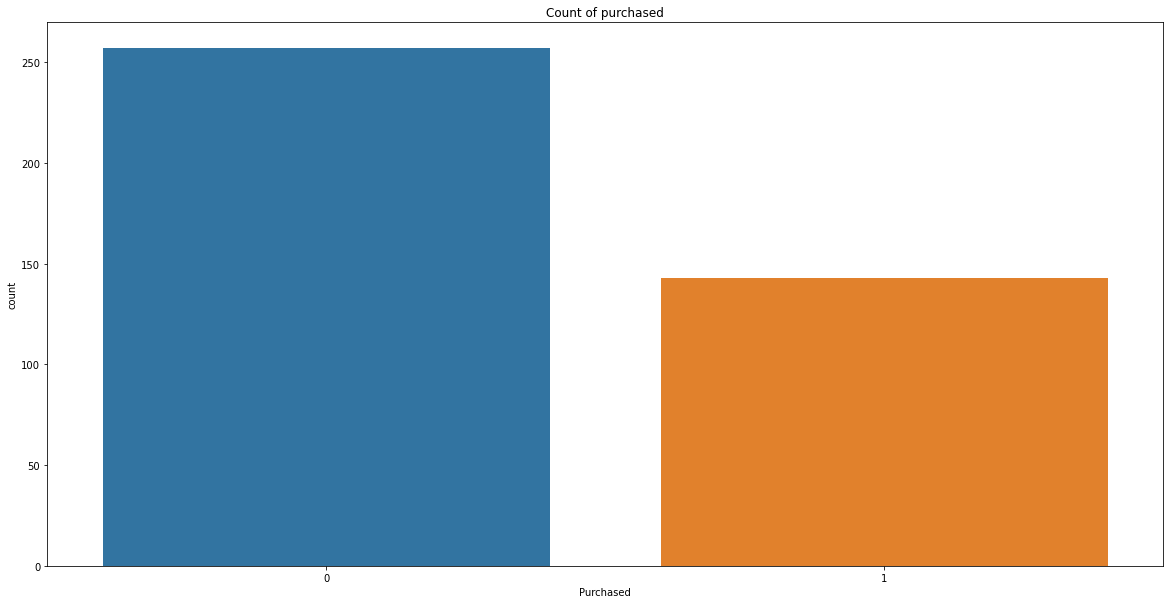

In [6]:
plt.figure(figsize=(20,10))
plt.title('Count of purchased')
sns.countplot(data=df,x='Purchased');

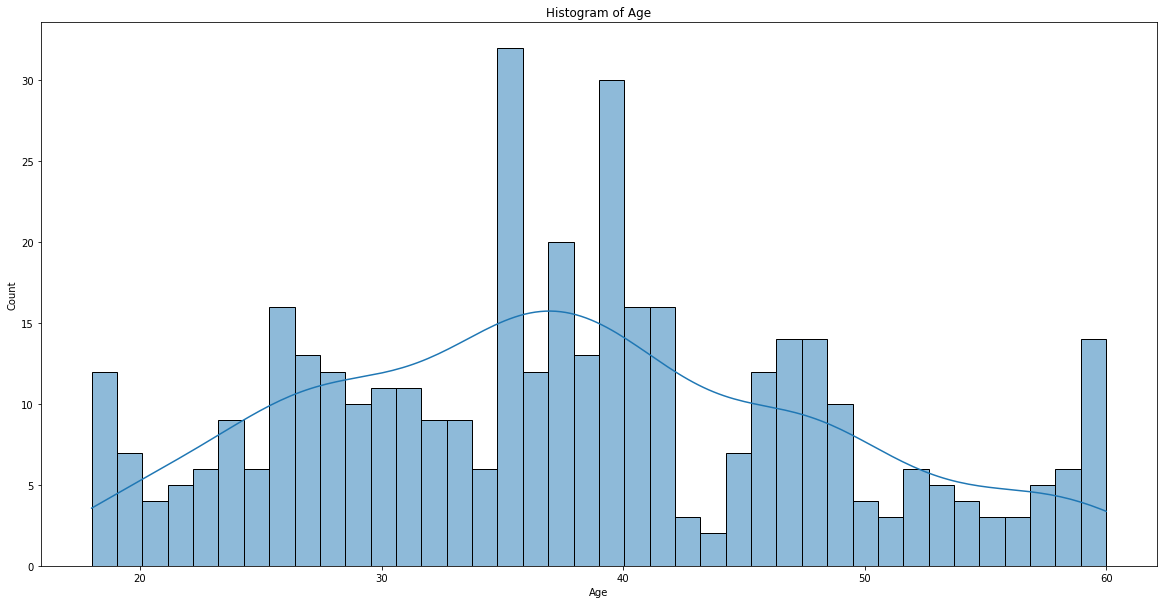

In [7]:
plt.figure(figsize=(20,10))
plt.title('Histogram of Age')
sns.histplot(data=df,x='Age',bins=40, kde=True);

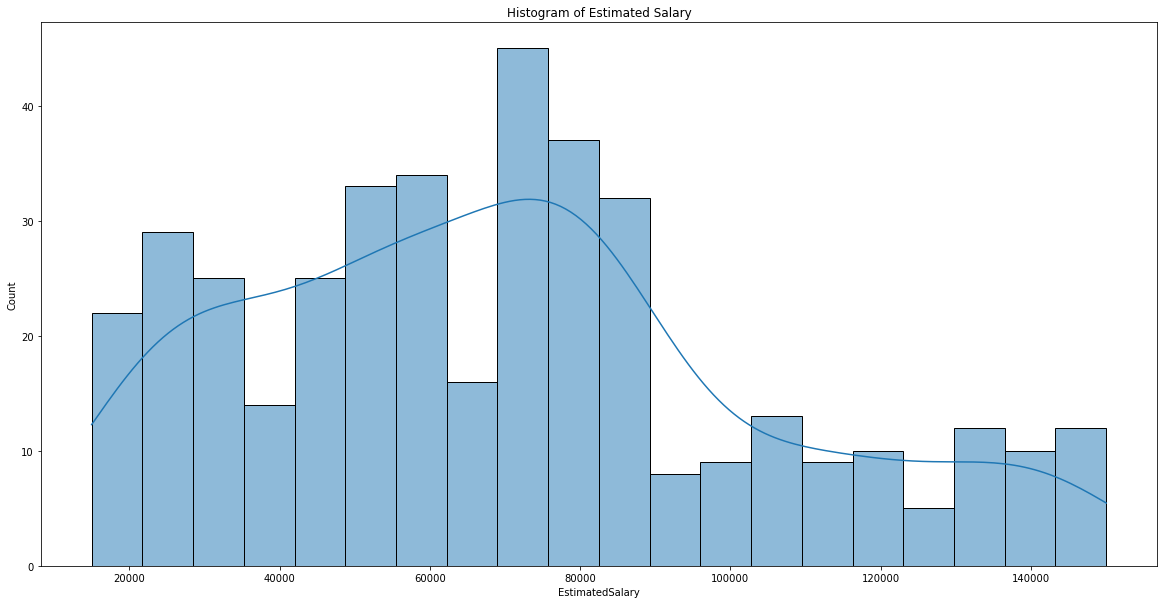

In [8]:
plt.figure(figsize=(20,10))
plt.title('Histogram of Estimated Salary')
sns.histplot(data=df,x='EstimatedSalary',bins=20, kde=True);

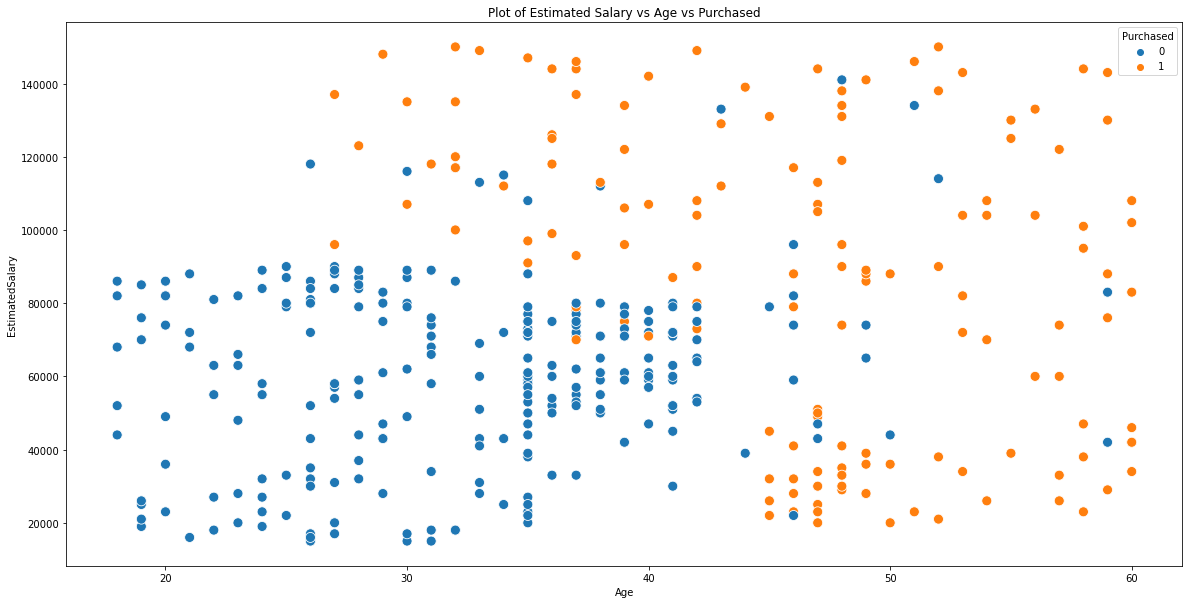

In [9]:
plt.figure(figsize=(20,10))
plt.title('Plot of Estimated Salary vs Age vs Purchased')
sns.scatterplot(data=df,x='Age',y= 'EstimatedSalary', hue='Purchased', s=100);

<AxesSubplot:title={'center':'Heat map of Correlation'}>

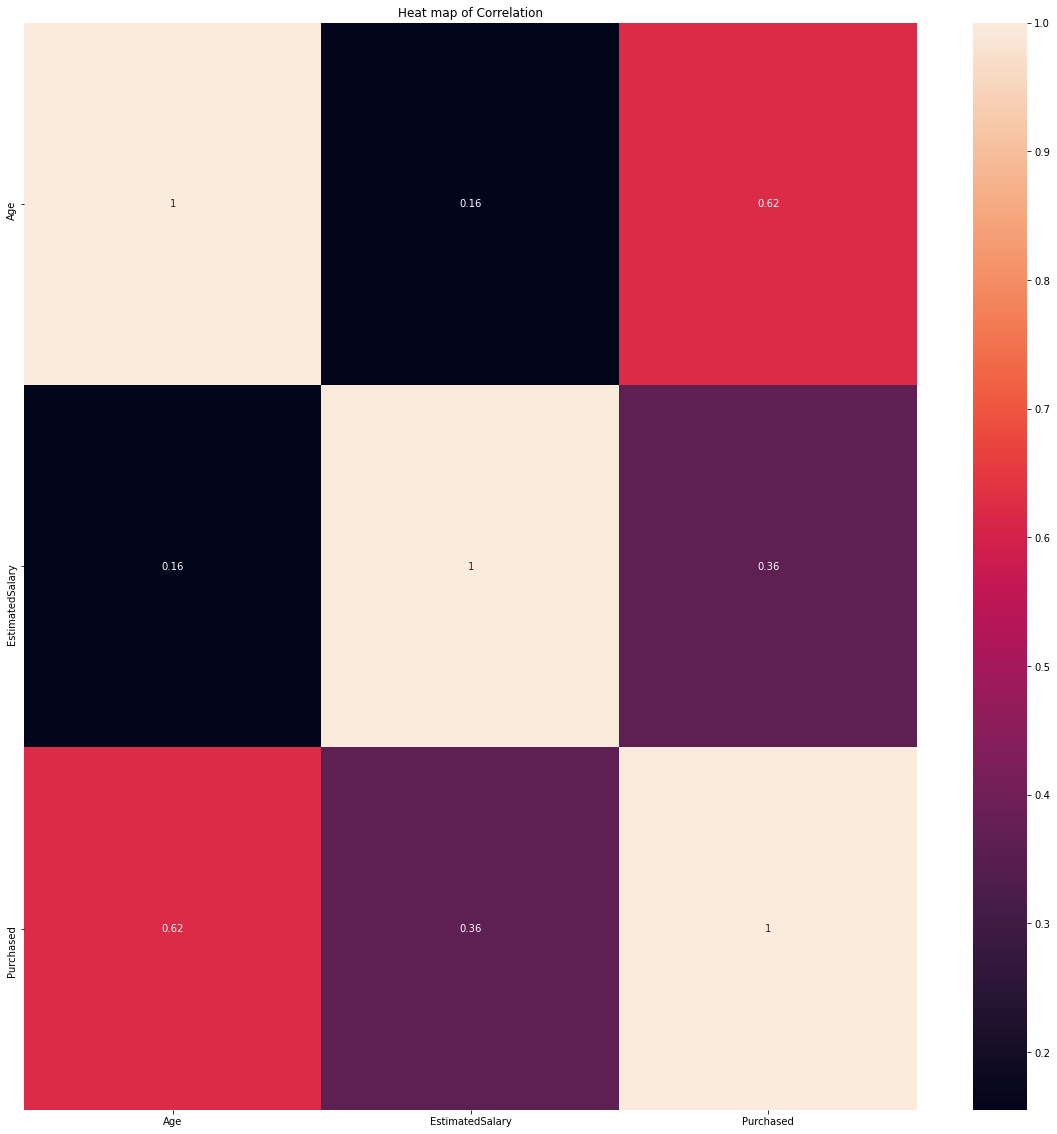

In [10]:
plt.figure(figsize=(20,20))
plt.title('Heat map of Correlation')
sns.heatmap(data=df.corr(), annot= True)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve

In [12]:
X = df.drop('Purchased', axis=1)
y = df['Purchased']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)    
    model_scores = {}    
    for name, model in models.items():
        model.fit(X_train,y_train)
        model_scores[name] = model.score(X_test,y_test)
    model_scores = pd.DataFrame(model_scores, index=['Score']).transpose()
    model_scores = model_scores.sort_values('Score')        
    return model_scores

In [15]:
models = {'LogisticRegression': LogisticRegression(max_iter=10000),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'SVC': SVC(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'RandomForestClassifier': RandomForestClassifier(),
          'AdaBoostClassifier': AdaBoostClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'XGBClassifier': XGBClassifier(eval_metric='mlogloss'),
          'XGBRFClassifier': XGBRFClassifier(eval_metric='mlogloss')}

In [16]:
baseline_model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
baseline_model_scores.sort_values('Score')

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,Score
DecisionTreeClassifier,0.8375
LogisticRegression,0.8625
GradientBoostingClassifier,0.8625
RandomForestClassifier,0.8875
AdaBoostClassifier,0.8875
KNeighborsClassifier,0.9125
XGBClassifier,0.9125
SVC,0.9250
XGBRFClassifier,0.9250


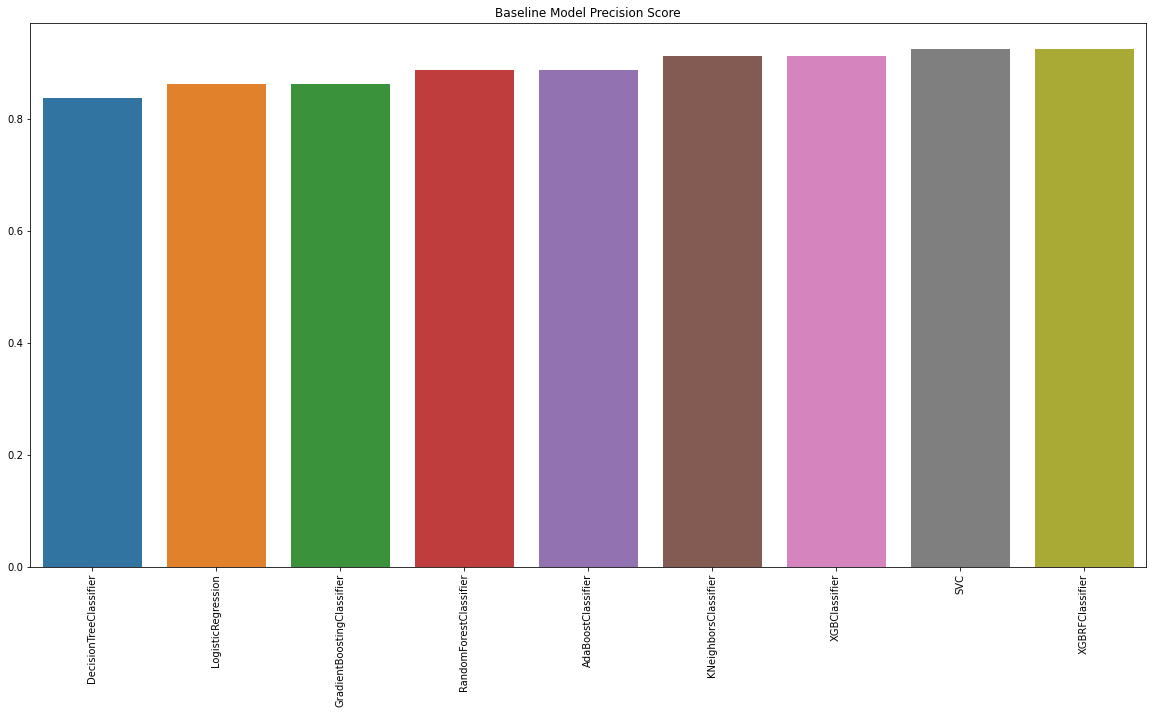

In [17]:
plt.figure(figsize=(20,10))
sns.barplot(data=baseline_model_scores.sort_values('Score').T)
plt.title('Baseline Model Precision Score')
plt.xticks(rotation=90);

In [18]:
def randomsearch_cv_scores(models, params, X_train, X_test, y_train, y_test):
    np.random.seed(42)    
    model_rs_scores = {}
    model_rs_best_param = {}    
    for name, model in models.items():
        rs_model = RandomizedSearchCV(model,param_distributions=params[name],cv=5,n_iter=20,verbose=1)
        rs_model.fit(X_train,y_train)
        model_rs_scores[name] = rs_model.score(X_test,y_test)
        model_rs_best_param[name] = rs_model.best_params_        
    return model_rs_scores, model_rs_best_param

In [19]:
params = {'KNeighborsClassifier' : {'n_neighbors': np.arange(1,100,10)},
          'XGBClassifier': {'learning_rate': np.linspace(0,1,20),
                            'gamma': [0,2,4,10,20,50],
                            'max_depth': [2,3,6,10,20],
                            'lambda': [0,1],
                            'alpha' : [0,0.1,0.2,0.5,0.8,1],
                            },
          'XGBRFClassifier': {'learning_rate': np.linspace(0,1,20),
                              'max_depth': [2,3,6,10,20],
                              },
          'SVC' : {'C': [0.1,0.5,1, 10,100,500], 
                   'kernel':['linear', 'poly', 'rbf','sigmoid'],
                   'gamma':['scale','auto'],
                   'degree':[2,3,4,5,6,7]}
          }
models = {'KNeighborsClassifier': KNeighborsClassifier(),
         'XGBClassifier': XGBClassifier(eval_metric='mlogloss'),
         'XGBRFClassifier': XGBRFClassifier(eval_metric='mlogloss'),
         'SVC': SVC()
         }

In [20]:
model_rs_scores_1, model_rs_best_param_1 = randomsearch_cv_scores(models, params, X_train, X_test, y_train, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   36.1s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished


In [21]:
model_rs_scores_1

{'KNeighborsClassifier': 0.925,
 'XGBClassifier': 0.9125,
 'XGBRFClassifier': 0.9125,
 'SVC': 0.9375}

In [22]:
model_rs_best_param_1

{'KNeighborsClassifier': {'n_neighbors': 11},
 'XGBClassifier': {'max_depth': 2,
  'learning_rate': 0.631578947368421,
  'lambda': 0,
  'gamma': 20,
  'alpha': 0},
 'XGBRFClassifier': {'max_depth': 2, 'learning_rate': 0.47368421052631576},
 'SVC': {'kernel': 'rbf', 'gamma': 'scale', 'degree': 7, 'C': 0.5}}

In [23]:
params = {'KNeighborsClassifier' : {'n_neighbors': np.arange(1,15)},
          'XGBClassifier': {'learning_rate': [0.631578947368421],
                            'gamma': [15,20,25],
                            'max_depth': [2],
                            'lambda': [0,1],
                            'alpha' : [0],
                            },
          'XGBRFClassifier': {'learning_rate': [0.47368421052631576],
                              'max_depth': [2],
                              },
          'SVC' : {'C': [0.3,0.4,0.5,0.6,0.7], 
                   'kernel':['rbf'],
                   'gamma':['scale'],
                   'degree':[7,8,9,10,15,20]}
          }
models = {'KNeighborsClassifier': KNeighborsClassifier(),
         'XGBClassifier': XGBClassifier(eval_metric='mlogloss'),
         'XGBRFClassifier': XGBRFClassifier(eval_metric='mlogloss'),
         'SVC': SVC()
         }

In [24]:
model_rs_scores_2, model_rs_best_param_2 = randomsearch_cv_scores(models, params, X_train, X_test, y_train, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 14 is smaller than n_iter=20. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   10.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [25]:
model_rs_scores_2

{'KNeighborsClassifier': 0.9375,
 'XGBClassifier': 0.9125,
 'XGBRFClassifier': 0.9125,
 'SVC': 0.925}

In [26]:
model_rs_best_param_2

{'KNeighborsClassifier': {'n_neighbors': 9},
 'XGBClassifier': {'max_depth': 2,
  'learning_rate': 0.631578947368421,
  'lambda': 0,
  'gamma': 15,
  'alpha': 0},
 'XGBRFClassifier': {'max_depth': 2, 'learning_rate': 0.47368421052631576},
 'SVC': {'kernel': 'rbf', 'gamma': 'scale', 'degree': 20, 'C': 0.6}}

In [27]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train,y_train)
y_preds = model.predict(X_test)

In [28]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        52
           1       0.87      0.96      0.92        28

    accuracy                           0.94        80
   macro avg       0.93      0.94      0.93        80
weighted avg       0.94      0.94      0.94        80



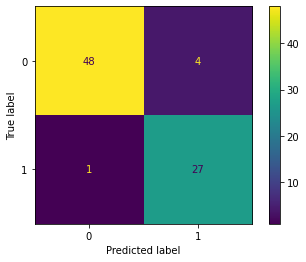

In [29]:
plot_confusion_matrix(model, X_test, y_test)

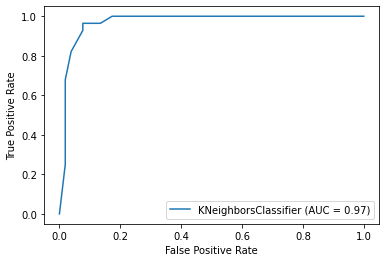

In [30]:
plot_roc_curve(model, X_test,y_test)